In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")
import torch
import torch_geometric
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from Scripts import train_metric_learning, run_metric_learning_inference, train_gnn, run_gnn_inference, build_track_candidates, evaluate_candidates
from Scripts.utils.convenience_utils import get_example_data, plot_true_graph, get_training_metrics, plot_training_metrics, plot_neighbor_performance, plot_predicted_graph, plot_track_lengths, plot_edge_performance, plot_graph_sizes
CONFIG = 'pipeline_config.yaml'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
help(torch_geometric)

Help on package torch_geometric:

NAME
    torch_geometric

PACKAGE CONTENTS
    data (package)
    datasets (package)
    debug
    deprecation
    experimental
    explain (package)
    graphgym (package)
    home
    io (package)
    loader (package)
    logging
    nn (package)
    profile (package)
    sampler (package)
    seed
    testing (package)
    transforms (package)
    typing
    utils (package)
    visualization (package)

CLASSES
    builtins.object
        torch_geometric.debug.debug
        torch_geometric.debug.set_debug
        torch_geometric.experimental.experimental_mode
        torch_geometric.experimental.set_experimental_mode
    
    class debug(builtins.object)
     |  Context-manager that enables the debug mode to help track down errors
     |  and separate usage errors from real bugs.
     |  
     |  Example:
     |  
     |      >>> with torch_geometric.debug():
     |      ...     out = model(data.x, data.edge_index)
     |  
     |  Methods defined he

In [7]:
data = torch.load("datasets/feature_store/quickstart_example_1GeV/1001")
#data = pd.read_csv("datasets/Quirk/event000001014-hits.csv")
data

Data(x=[682, 3], pid=[682], event_file='datasets/Quirk/event000001001', hid=[682], pt=[682], modulewise_true_edges=[2, 595], layerwise_true_edges=[2, 595])

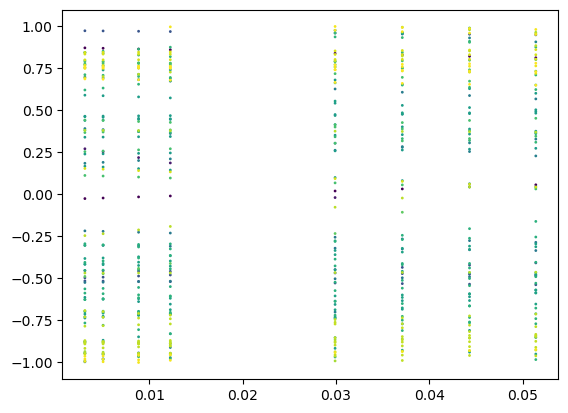

In [8]:
plt.scatter(data.x[:,0], data.x[:,1], c=data.pid, s=1)

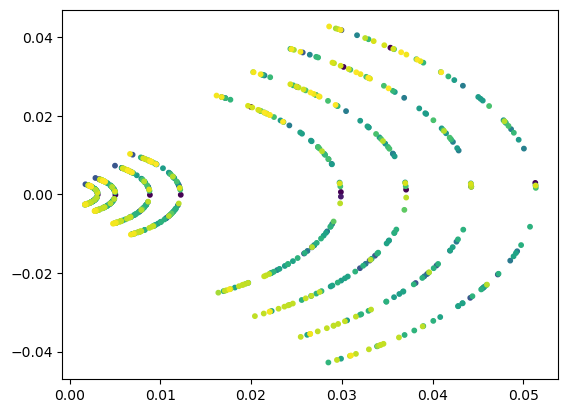

In [9]:
r, phi, z = data.x[:, 0], data.x[:, 1], data.x[:, 2]
x,y = r * torch.cos(phi), r * torch.sin(phi)
plt.scatter(x, y, s=10, c=data.pid)

# 0. Download Data

### Pipeline configurations

The configurations for the entire pipeline are defined under pipeline_config.yml. 

In [10]:
import yaml
with open(CONFIG, 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)

# 1. Train Metric Learning

## What it does
Broadly speaking, the first stage of our pipeline is embedding the space points on to graphs, in a way that is efficient, i.e. we miss as few points on a graph as possible. We train a MLP to transform the input feature vector of each space point $\mathbf{u}_i$ into an N-dimensional latent space $\mathbf{v}_i$. The graph is then constructed by connecting the space points whose Euclidean distance between the latent space points $$d_{ij} = \left| \mathbf{v}_i - \mathbf{v}_j \right| < r_{embedding}$$

## Training data
Let us take a look at the data before training. In this example pipeline, we have preprocessed the TrackML data into a more convenient form. We calculated directional information and summary statistics from the charge deposited in each spacepoints, and append them to its cyclidrical coordinates. Let us load an example data file and inspect the content.

In [11]:
example_data_df, example_data_pyg = get_example_data(configs)
example_data_df.head()

,0,1,2
0,0.00310,-0.141699,0.00312
1,0.00505,-0.135518,0.00508
2,0.00885,-0.123188,0.00888
3,0.01225,-0.111993,0.01232
4,0.02990,-0.053353,0.03052


In [12]:
plot_true_graph(example_data_pyg, num_tracks=200)

## Train metric learning model

Finally we come to model training. By default, we train the MLP for 30 epochs, which takes approximately 15 minutes on an NVidia V100. Feel free to adjust the epoch number in pipeline_config.yml

In [13]:
metric_learning_trainer, metric_learning_model = train_metric_learning(CONFIG)

-------------------- Step 1: Running metric learning training --------------------
----------------------------- a) Initialising model -----------------------------
------------------------------ b) Running training ------------------------------


/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 3.2 M 
---------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.694    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/78 [00:00<?, ?it/s]                            

/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:362: LightningDeprecationWarning: The NVIDIA/apex AMP implementation has been deprecated upstream. Consequently, its integration inside PyTorch Lightning has been deprecated in v1.9.0 and will be removed in v2.0.0. The `LayerlessEmbedding.optimizer_step()` hook is overridden, including the `using_native_amp` argument. Removing this argument will avoid this message, you can expect it to return True.
  rank_zero_deprecation(


Epoch 9: 100%|██████████| 78/78 [00:22<00:00,  3.50it/s, loss=0.00891, v_num=7]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 78/78 [00:22<00:00,  3.45it/s, loss=0.00891, v_num=7]
-------------------------------- c) Saving model --------------------------------


## Plot training metrics

We can examine how the training went. This is stored in a simple dataframe:

In [14]:
embedding_metrics = get_training_metrics(metric_learning_trainer)
embedding_metrics.head()

,epoch,train_loss,val_loss,eff,pur,current_lr
0,0,0.009418,0.008096,0.990541,0.012669,0.000125
1,1,0.009224,0.005646,0.959356,0.047121,0.000250
2,2,0.009062,0.004982,0.940533,0.073470,0.000375
3,3,0.009020,0.004800,0.960990,0.084239,0.000350
4,4,0.008932,0.004781,0.960715,0.078911,0.000625


In [15]:
plot_training_metrics(embedding_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [16]:
plot_neighbor_performance(metric_learning_model)

RuntimeError: max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

## Plot example truth and predicted graphs

In [17]:
plot_predicted_graph(metric_learning_model)

## Track lengths

In [18]:
plot_track_lengths(metric_learning_model)

100%|██████████| 70/70 [00:15<00:00,  4.40it/s]


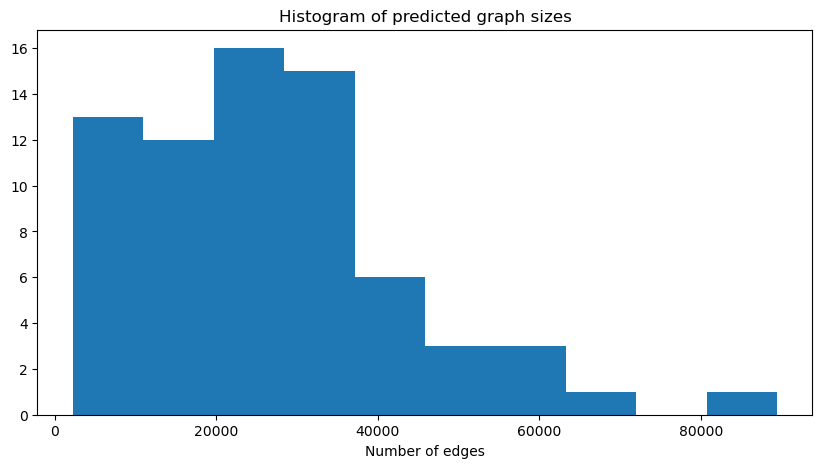

In [19]:
plot_graph_sizes(metric_learning_model)

# 2. Construct graphs from metric learning inference

This step performs model inference on the entire input datasets (train, validation and test), to obtain input graphs to the graph neural network. Optionally, we also clear the directory.

In [21]:
graph_builder = run_metric_learning_inference(CONFIG)

------------- Step 2: Constructing graphs from metric learning model -------------
---------------------------- a) Loading trained model ----------------------------
----------------------------- b) Running inferencing -----------------------------
Training finished, running inference to build graphs...


 26%|██▌       | 18/70 [00:04<00:12,  4.06it/s]


RuntimeError: max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

# 3. Train graph neural networks

We have a set of graphs constructed. We now train a GNN to classify edges as either "true" (belonging to the same track) or "false" (not belonging to the same track). We train for 30 epochs, which should take around 10 minutes on a V100 GPU. Your mileage may vary.

In [22]:
gnn_trainer, gnn_model = train_gnn(CONFIG)

-------------------------  Step 3: Running GNN training  -------------------------
----------------------------- a) Initialising model -----------------------------
------------------------------ b) Running training ------------------------------


/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 34.0 K
1 | edge_encoder           | Sequential | 66.4 K
2 | edge_network           | Sequential | 82.8 K
3 | node_network           | Sequential | 82.8 K
4 | output_edge_classifier | Sequential | 83.2 K
------------------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K   

/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:110: UserWarning: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(
/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch

Epoch 0:   0%|          | 0/18 [00:00<?, ?it/s] 

/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:362: LightningDeprecationWarning: The NVIDIA/apex AMP implementation has been deprecated upstream. Consequently, its integration inside PyTorch Lightning has been deprecated in v1.9.0 and will be removed in v2.0.0. The `InteractionGNN.optimizer_step()` hook is overridden, including the `using_native_amp` argument. Removing this argument will avoid this message, you can expect it to return True.
  rank_zero_deprecation(


Epoch 29: 100%|██████████| 18/18 [00:00<00:00, 21.62it/s, loss=0.396, v_num=4]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 18/18 [00:00<00:00, 20.01it/s, loss=0.396, v_num=4]
-------------------------------- c) Saving model --------------------------------


## Plot training metrics

In [23]:
gnn_metrics = get_training_metrics(gnn_trainer)
gnn_metrics.head()

KeyError: 'val_loss'

In [24]:
plot_training_metrics(gnn_metrics)

NameError: name 'gnn_metrics' is not defined

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [25]:
plot_edge_performance(gnn_model)

IndexError: list index out of range

# Step 4: GNN inference 

In [26]:
run_gnn_inference(CONFIG)

--------------------- Step 4: Scoring graph edges using GNN  ---------------------
---------------------------- a) Loading trained model ----------------------------
----------------------------- b) Running inferencing -----------------------------
Training finished, running inference to filter graphs...
Building train


  0%|          | 0/18 [00:00<?, ?it/s]/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 18/18 [00:00<00:00, 27.41it/s]


Building val


0it [00:00, ?it/s]


Building test


0it [00:00, ?it/s]


# Step 5: Build track candidates from GNN

In [27]:
build_track_candidates(CONFIG)

-----------  Step 5: Building track candidates from the scored graph  -----------
---------------------------- a) Loading scored graphs ----------------------------
---------------------------- b) Labelling graph nodes ----------------------------


100%|██████████| 18/18 [00:00<00:00, 74.35it/s]


# Step 6: Evaluate track candidates

We can control the matching style in the pipeline config file. The following all require at least a majority of hits to match in each scheme (i.e. matching fraction = 50%).
A discussion of each matching style and some worked examples can be found in the [Documentation](https://hsf-reco-and-software-triggers.github.io/Tracking-ML-Exa.TrkX/performance/matching_definitions/).

ATLAS style matching is the default.

In [28]:
evaluated_events, reconstructed_particles, particles, matched_tracks, tracks = evaluate_candidates(CONFIG)

------------ Step 6: Evaluating the track reconstruction performance ------------
--------------------------- a) Loading labelled graphs ---------------------------


100%|██████████| 18/18 [00:00<00:00, 25.81it/s]

--------------------- b) Calculating the performance metrics ---------------------
Number of reconstructed particles: 0
Number of particles: 1834
Number of matched tracks: 0
Number of tracks: 0
Number of duplicate reconstructed particles: 0


ZeroDivisionError: division by zero